# CS/ECE/ISyE 524 — Introduction to Optimization — Spring 2025

# Profit-Maximizing Experiment Selection: MIP vs. LP

Juner Lu(jlu436@wisc.edu), Anda He(ahe28@wisc.edu)

- [1. Introduction](#Introduction)
- [2. Mathematical Model](#MathematicalModel)
- [3. Solution](#Solution)
- [4. Discussion](#Discussion)
- [5. Conclusion](#Conclusion)

<a id="Introduction"></a>
## 1. Introduction

### 1.a Context

In recent years, driven by SpaceX's breakthroughs in reusable rockets and dramatic reductions in launch costs, a new era of commercial spaceflight has emerged. With the cost of access to space falling and the diversity of payload applications expanding, commercial experiments in microgravity environments are in soaring demand. Beyond traditional satellite deployments for remote sensing and communications, research institutions, university laboratories, and industries such as biotechnology and materials science now vie for limited flight opportunities to conduct high-value experiments in orbit.

Professor W works for a leading commercial spaceflight company and is assigned to plan a specific mission. He must decide which experiments (E = {$E_1, E_2, ..., E_m$}) to run and which instruments (I = {$I_1, I_2, ..., I_n$}) to bring. Each experiment yields a profit ($p_j$) and requires certain instruments ($R_j \subseteq I$), and each instrument incurs a configuration cost (c_k). The objective is to maximize the net profit of this mission.

![space](./image0.png)

After we completed the CS524 course, when we saw this problem, Mixed-integer programming was the first modeling method that came to mind. Mixed-integer programming has grown from Dantzig’s 1947 simplex algorithm into a robust framework that integrates cutting-plane methods and branch-and-bound techniques for 0-1 optimization ([https://en.wikipedia.org/wiki/Integer\_programming](https://en.wikipedia.org/wiki/Integer_programming)). Bixby’s 2010 survey documents these milestones, tracing the evolution of MIP solvers from their theoretical origins to today’s high-performance engines ([https://citeseerx.ist.psu.edu/document?doi=fb0921851f1bb77df1b663c515c75a7d888b1f93](https://citeseerx.ist.psu.edu/document?doi=fb0921851f1bb77df1b663c515c75a7d888b1f93)).

However, while building our model, we found that the max-flow linear program is also a viable modeling method. Maximum-flow LP originated from Harris and Ross’s 1954 network-flow formulation and was first solved by Ford and Fulkerson’s 1956 augmenting-path method, culminating in their 1962 max-flow/min-cut theorem ([https://en.wikipedia.org/wiki/Ford%E2%80%93Fulkerson\_algorithm](https://en.wikipedia.org/wiki/Ford%E2%80%93Fulkerson_algorithm)). Subsequent refinements—Edmonds-Karp’s shortest-augmenting-path rule in 1972, Dinic’s blocking-flow approach in 1970, and Goldberg-Tarjan’s push-relabel method in 1988—yielded ever-faster polynomial-time solvers for large networks.

Therefore, we aim to compare the solving speed of different methods for this problem. In addition, to explore faster solution methods, we implemented Dinic’s network‐flow algorithm in Julia, achieving more efficient results for this class of integer optimization problems.


### 1.b Feasibilty analysis

This problem resembles the Generalized Assignment Problem (GAP) we saw in class, if we map machines to experiments and jobs to instruments. In both cases we introduce binary variables to track which items are chosen. However, our goal is different: we do not have any per-assignment cost, and each experiment has a fixed set of required instruments. On the other hand, each experiment also brings profits. If we represent profits, experiments, instruments and costs as a graph—just like we did in class—the structure looks like this:

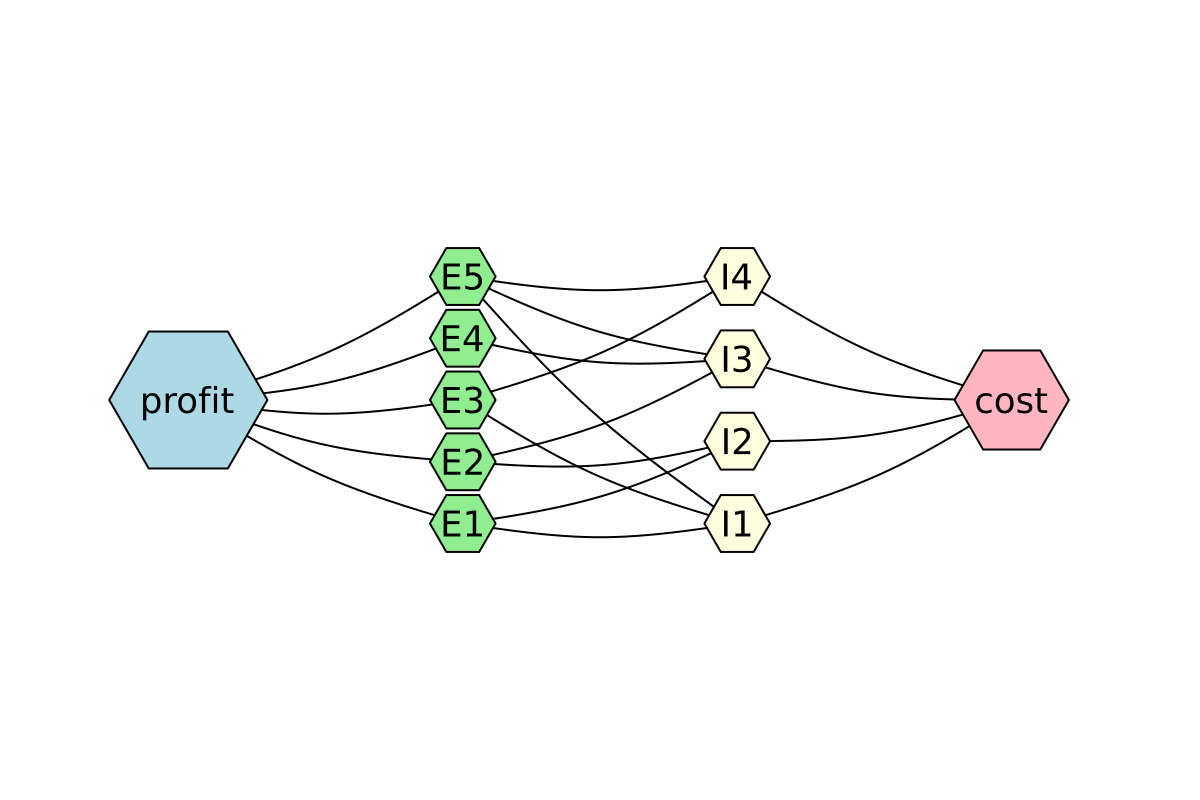

In [1]:
using Graphs, GraphRecipes, Plots
function plot_experiment_instrument_graph(m::Int, n::Int)
    total=m+n+2
    s,sink=1,total
    g=SimpleGraph(total)
    deps=[[1,2],[2,3],[1,4],[3],[1,3,4]]
    for j in 1:m
        add_edge!(g,s,1+j)
        for k in deps[j] add_edge!(g,1+j,m+1+k) end
    end
    for k in 1:n add_edge!(g,m+1+k,sink) end
    names=[i==s ? "profit" : i==sink ? "cost" : i<=m+1 ? "E$(i-1)" : "I$(i-m-1)" for i in 1:total]
    elabel=String[]
    for e in edges(g)
        u,v=src(e),dst(e)
        if u==s||v==s push!(elabel,"profit") elseif u==sink||v==sink push!(elabel,"cost") else push!(elabel,"dependency") end
    end
    x=zeros(total);y=zeros(total)
    x[s],y[s]=0,0.5
    x[sink],y[sink]=3,0.5
    exp_ys=range(0.05,0.95,length=m)
    for(j,yy)in enumerate(exp_ys) x[1+j],y[1+j]=1,yy end
    ins_ys=range(0.05,0.95,length=n)
    for(k,yy)in enumerate(ins_ys) x[m+1+k],y[m+1+k]=2,yy end
    fill_colors=[i==s ? :lightblue : i==sink ? :lightpink : i<=m+1 ? :lightgreen : :lightyellow for i in 1:total]
    graphplot(g; x=x,y=y,names=names,edge_labels=elabel,method=:none,arrow=false,nodesize=0.25,nodecolor=fill_colors,nodestrokecolor=:black,nodefillalpha=1.0,fontsize=12,dpi=200)
end
plot_experiment_instrument_graph(5,4)


Since our objective is to maximize profit, and with the appropriate constraints in place, a mixed‐integer programming model can effectively solve this problem.

Combining the graph drawn when we confirmed the MIP model's feasibility, we see a directed network with capacity constraints and two special nodes, $s$ and $t$. The source $s$ represents the incoming profit, and the sink $t$ represents the outgoing cost. There are dependency arcs: if an experiment is selected, its successor instrument must also be selected. From this diagram we can quickly read the flow semantics: we define the flow as

> the destination of one unit of profit leaving $s$

To analyze feasibility, we define a simple cut. Partition the vertex set $V$ into $S$ and its complement $T = V - S$, with $s \in S$ and $t \in T$, and consider the minimum cut.

**Graph construction** (same as above):  
- Connect $s$ (profit) to each experiment $e \in E$ with capacity equal to its sponsorship amount.  
- Connect each instrument $i \in I$ to $t$ (cost) with capacity equal to its configuration cost.  
- Connect each experiment $e_i$ to each instrument $i_i$ it depends on with infinite capacity, meaning one unit of profit can be freely assigned to any required instrument.

We must balance experiment sponsorship against instrument cost to maximize $\text{profit} - \text{cost}.$

Revisiting the simple cut, since dependency arcs have infinite capacity, we observe:

1. For each experiment $e_i$ in $S$, all its dependent instruments also lie in $S$.  
   If $e_i$ is in $S$, the arc $(s,e_i)$ still has spare capacity. If any instrument-to-$t$ arc also had spare capacity, the flow would not be saturated and no cut would form.

2. The resulting cut exactly corresponds to a valid choice of experiments and instruments.  
   From (1), any experiment in $S$ has used up its sponsorship and paid for its instruments. Any experiment $e_j$ not in $S$ has fully used the arc $(s,e_j)$, thereby forfeiting its sponsorship.

Combining these, a maximum flow captures both selecting experiments and paying instrument costs, and forfeiting experiment sponsorship.

Let $SUM = \sum_{e \in E} \text{profit}(e),$ and let $Min\_Cut$ be the capacity of the minimum $s$-$t$ cut.

Then the maximum net profit is $SUM - Min\_Cut.$  


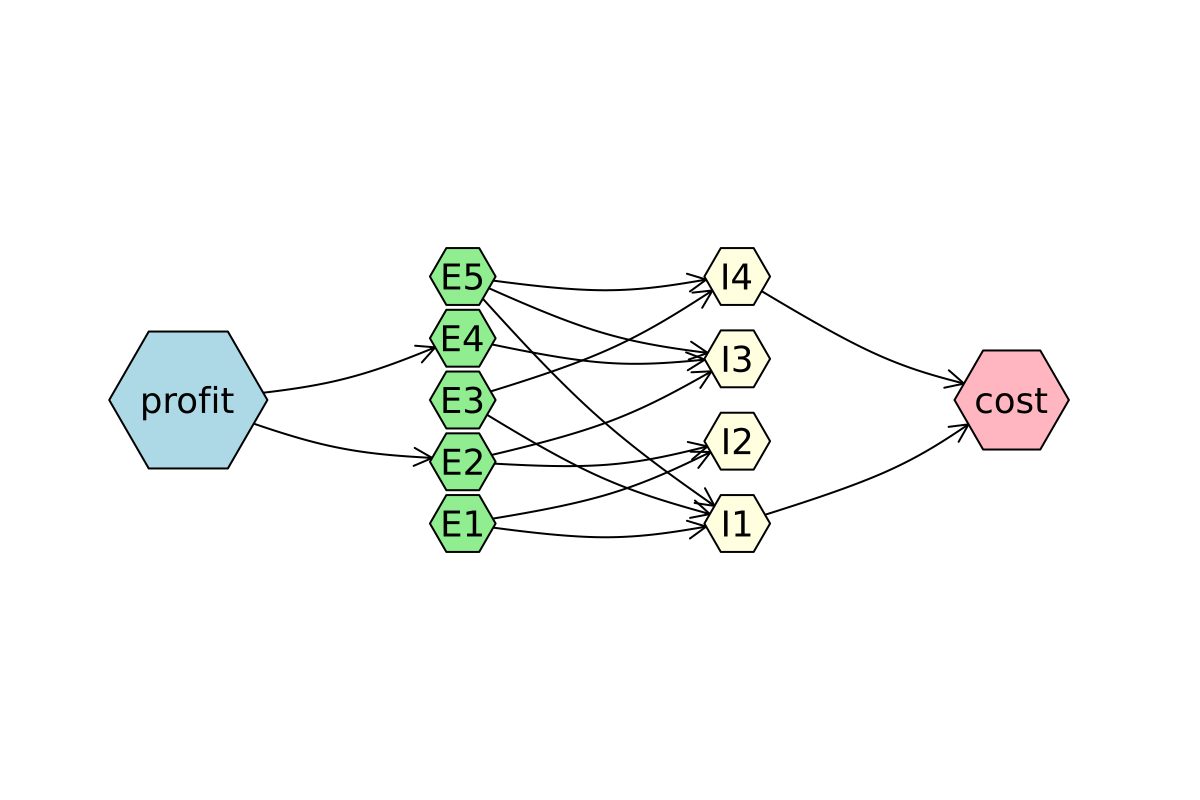

In [1]:
using Graphs, GraphRecipes, Plots
function plot_experiment_instrument_graph(m::Int, n::Int)
    total = m + n + 2
    s, sink = 1, total
    g = SimpleDiGraph(total)
    deps = [[1,2], [2,3], [1,4], [3], [1,3,4]]
    for j in 1:m
        if j != 1 && j != 3 && j != 5
            add_edge!(g, s, 1 + j)
        end
        for k in deps[j]
            add_edge!(g, 1 + j, m + 1 + k)
        end
    end
    for k in 1:n
        if k != 2 && k != 3
            add_edge!(g, m + 1 + k, sink)
        end
    end
    names = [ i == s ? "profit" :
           i == sink ? "cost" :
           i <= m + 1 ? "E$(i-1)" :
                      "I$(i-m-1)"
           for i in 1:total ]
    elabel = String[]
    for e in edges(g)
        u, v = src(e), dst(e)
        if u == s || v == s
            push!(elabel, "profit")
        elseif u == sink || v == sink
            push!(elabel, "cost")
        else
            push!(elabel, "dependency")
        end
    end
    x = zeros(total); y = zeros(total)
    x[s],    y[s]    = 0,   0.5
    x[sink], y[sink] = 3,   0.5
    exp_ys = range(0.05, 0.95, length = m)
    for (j, yy) in enumerate(exp_ys)
        x[1 + j], y[1 + j] = 1, yy
    end
    ins_ys = range(0.05, 0.95, length = n)
    for (k, yy) in enumerate(ins_ys)
        x[m + 1 + k], y[m + 1 + k] = 2, yy
    end
    fill_colors = [ i == s ? :lightblue  :
              i == sink ? :lightpink  :
              i <= m + 1 ? :lightgreen :
                         :lightyellow
              for i in 1:total ]
    graphplot(
        g;
        x = x,
        y = y,
        names = names,
        edge_labels = elabel,
        method = :none,
        arrow = true,
        nodesize = 0.25,
        nodecolor = fill_colors,
        nodestrokecolor = :black,
        nodefillalpha = 1.0,
        fontsize = 12,
        dpi = 200
    )
end
plot_experiment_instrument_graph(5,4)


Since this is a directed graph, the cut shown in the figure constitutes a valid minimum cut.

<a id="MathematicalModel"></a>
## 2. Mathematical Model

### 2.a Mix Integer Program Model

1.Decision variables:

$$
x_j =
\begin{cases}
1, & \text{if experiment }E_j\text{ is selected for the flight},\\
0, & \text{otherwise},
\end{cases}
\quad
y_k =
\begin{cases}
1, & \text{if instrument }I_k\text{ is configured},\\
0, & \text{otherwise}.
\end{cases}
$$

2.Constraints:

The logic statement for $x_j$ and $y_k$ is: \
If $x_j$ = 1, then $y_k$ = 1, $\forall k \in R_j$. \
The implication is equivalent to the inequality: \
$x_j \le y_k, \forall k \in R_j$
3.Objective:
$$\operatorname*{min} \quad \sum_{j = 1}^m (p_j x_j) - \sum_{k = 1}^n (c_k y_k)$$

The Mathematical Model is:

$$
\begin{aligned}
\operatorname*{min} \quad & \sum_{j = 1}^m (p_j x_j) - \sum_{k = 1}^n (c_k y_k) \\
\text{s.t. } \quad & x_j \le y_k, \forall k \in R_j, \forall i \in \{1,...,m\} \\
& x_j \text{ binary}, y_k \text{ binary}, \forall i \in \{1,...,m\}, \forall k \in \{1,...,n\}
\end{aligned}
$$

### 2.b  Linear Program Model

1.Decision variables:

$x_{jk}$ : The flow from node $j$ to instrument node $k$
Besides:

Let A be the edge set and s be the source node and t be the sink node. \
$u_{jk}$ : The maximum capacity of the flow $x_{jk}$ \
$v$ : The total traffic in the entire network

2.Constraints:

$$
\begin{aligned}
\sum_{k:(j,k) \in A} x_{jk} - \sum_{k:(k,j) \in A} x_{kj} & = 0, \forall j \in \{1,...,m\}, j \neq s, k \neq t \\
\sum_{j:(s,j) \in A} x_{sj} - \sum_{j:(j,s) \in A} x_{js} - v & = 0, \forall j \in \{1,...,m\} \\
\sum_{k:(t,k) \in A} x_{tk} - \sum_{k:(k,t) \in A} x_{kt} + v & = 0, \forall k \in \{1,...,n\} \\
x_{jk} & \le u_{jk}, \forall (j,k) \in A \\
x_{jk} & \ge 0, \forall (j,k) \in A
\end{aligned}
$$

3.Objective

$$\operatorname*{max} \quad v$$
The Mathematical Model is:

$$
\begin{aligned}
\operatorname*{max} \quad & v \\
\text{s.t.} \quad \sum_{k:(j,k) \in A} x_{jk} - \sum_{k:(k,j) \in A} x_{kj} & = 0, \forall j \in \{1,...,m\}, j \neq s, k \neq t \\
\sum_{j:(s,j) \in A} x_{sj} - \sum_{j:(j,s) \in A} x_{js} - v & = 0, \forall j \in \{1,...,m\} \\
\sum_{k:(t,k) \in A} x_{tk} - \sum_{k:(k,t) \in A} x_{kt} + v & = 0, \forall k \in \{1,...,n\} \\
x_{jk} & \le u_{jk}, \forall (j,k) \in A \\
x_{jk} & \ge 0, \forall (j,k) \in A
\end{aligned}
$$

<a id="Solution"></a>
## 3. Solution

### Model Validation
> We generate $300+10$ blocks of dataset to verify our code. 300 for time comparison and 10 for credibility validation.

In order to verify the correctness of the model, we constructed ten high-quality, hand-crafted datasets (publicly available on our GitHub: https://github.com/junerlu/cs524) by manual schematic plotting to verify the correctness of the three models. The results show that, on both hand-crafted and randomly generated data, all three models produce consistent outcomes.

| File      | MIP net profit | MaxFlow-LP covered | Dinic min-cut |
| --------- | -------------- | ------------------ | ------------- |
| shut1.in  | **12.00**      | 12.00              | 12.00         |
| shut2.in  | **3.00**       | 3.00               | 3.00          |
| shut3.in  | **170.00**     | 170.00             | 170.00        |
| shut4.in  | **96.00**      | 96.00              | 96.00         |
| shut5.in  | **2.00**       | 2.00               | 2.00          |
| shut6.in  | **27.00**      | 27.00              | 27.00         |
| shut7.in  | **16.00**      | 16.00              | 16.00         |
| shut8.in  | **23.00**      | 23.00              | 23.00         |
| shut9.in  | **8.00**       | 8.00               | 8.00          |
| shut10.in | **11.00**      | 11.00              | 11.00         |

Only the results are shown here, and the outcomes across all 300 datasets used later are consistent. The code is identical to the version presented later, differing only in the final printed output.

### Data Source

Next, to fully compare the differences between the two models, we used 300 carefully designed synthetic datasets and made both these datasets and the code that generated them publicly available on our GitHub (https://github.com/junerlu/cs524). Assuming the number of experiments is $M$ and the number of instruments is $N$, our datasets cover cases where $M$ ranges from 2 to 600 and $N$ ranges from 3 to 900, with filenames arranged in ascending order of data size.

### 3.a Mix Integer Program

In [4]:
using JuMP, HiGHS
using Printf

function read_and_solve_mip(filename::String)
    open(filename, "r") do io
        # read number of experiments and instruments
        m, n = parse.(Int, split(readline(io)))
        
        # read payments p_j and required instruments R_j
        p = Vector{Float64}(undef, m)
        R = [Int[] for _ in 1:m]
        for j in 1:m
            parts = parse.(Int, split(readline(io)))
            p[j] = parts[1]
            R[j] = parts[2:end]
        end

        # read instrument configuration costs c_k
        c = parse.(Float64, split(readline(io)))
        
        solve_experiment_selection(m, n, p, R, c)
    end
end

function solve_experiment_selection(m, n, p, R, c)
    model = Model(HiGHS.Optimizer)
    set_optimizer_attribute(model, "output_flag", false)
    # decision variables
    @variable(model, x[1:m], Bin)   # 1 if experiment j is selected
    @variable(model, y[1:n], Bin)   # 1 if instrument k is configured

    # linking constraints: if experiment j is chosen, all required instruments must be configured
    for j in 1:m
        for k in R[j]
            @constraint(model, x[j] <= y[k])
        end
    end

    # objective: maximize total payment minus total configuration cost
    @objective(model, Max,
        sum(p[j] * x[j] for j in 1:m)
      - sum(c[k] * y[k] for k in 1:n)
    )

    # solve
    optimize!(model)

    return value.(x), value.(y)
end

solve_experiment_selection (generic function with 1 method)

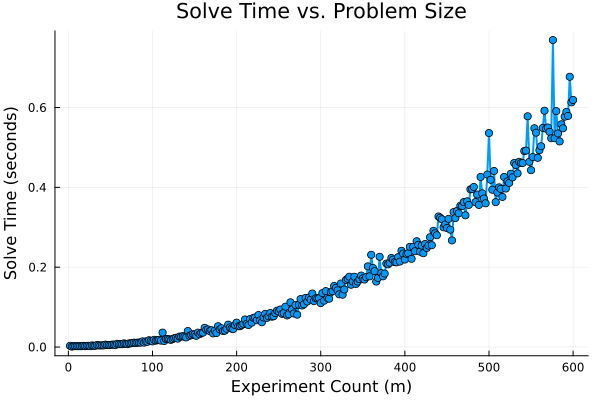

In [6]:
using Dates
using Plots
using Printf

sizes = Int[]
times = Float64[]

for i in 1:300
    filename = @sprintf("%d.in", i)
    tstart = now()
    read_and_solve_mip(filename)
    push!(sizes, i*2)
    tend = now()
    elapsed = (tend - tstart).value / 1000
    push!(times, elapsed)
end

plot(sizes, times,
     xlabel="Experiment Count (m)",
     ylabel="Solve Time (seconds)",
     title="Solve Time vs. Problem Size",
     marker=:circle,
     lw=2,
     legend=false)

## 3.b Linear Program

In [7]:
using JuMP, HiGHS
using Printf

# read_and_solve : read instance → call solve_max_flow_lp → return covered amount
function read_and_solve(filename::String)
    open(filename, "r") do io
        m, n                 = parse.(Int, split(readline(io)))
        pay                  = Vector{Int}(undef, m)
        need                 = [Int[] for _ in 1:m]

        for j in 1:m
            row              = parse.(Int, split(readline(io)))
            pay[j]           = row[1]
            need[j]          = row[2:end]
        end
        cost                 = parse.(Int, split(readline(io)))

        N  = 2 + m + n                       # s + experiments + instruments + t
        s  = 1
        t  = N
        e0 = 1                               # experiment start offset (nodes 2..m+1)
        i0 = 1 + m                           # instrument start offset (nodes m+2..N-1)
        BIG = sum(pay)                       # upper bound for “infinite” capacity

        # construct arc set A, capacities cap, adjacency lists out / inn
        A   = Vector{Tuple{Int,Int}}()
        cap = Dict{Tuple{Int,Int},Int}()

        out = Dict(i=>Int[] for i in 1:N)
        inn = Dict(i=>Int[] for i in 1:N)

        # s → experiments, experiments → instruments
        for j in 1:m
            ej = e0 + j
            push!(A, (s, ej));     cap[(s, ej)] = pay[j]
            push!(out[s], ej);     push!(inn[ej], s)

            for k in need[j]
                ik = i0 + k
                push!(A, (ej, ik)); cap[(ej, ik)] = BIG   # large constant capacity
                push!(out[ej], ik); push!(inn[ik], ej)
            end
        end

        # instruments → t
        for k in 1:n
            ik = i0 + k
            push!(A, (ik, t));     cap[(ik, t)] = cost[k]
            push!(out[ik], t);     push!(inn[t], ik)
        end

        solve_max_flow_lp(N, A, cap, s, t, sum(pay), out, inn)
    end
end

# solve_max_flow_lp : pure arc-based variables, efficient flow conservation + capacity constraints
function solve_max_flow_lp(N, A, cap, s, t, total_pay, out, inn)
    model = Model(HiGHS.Optimizer)
    set_optimizer_attribute(model, "output_flag", false)

    @variable(model, x[e in A] >= 0)
    @variable(model, v >= 0)
    @objective(model, Max, v)

    # flow conservation for intermediate nodes
    for i in 1:N
        (i == s || i == t) && continue
        @constraint(model,
            sum(x[(i, j)] for j in out[i]) -
            sum(x[(j, i)] for j in inn[i]) == 0)
    end

    # source and sink constraints
    @constraint(model,
        sum(x[(s, j)] for j in out[s]) -
        sum(x[(j, s)] for j in inn[s]) - v == 0)

    @constraint(model,
        sum(x[(t, j)] for j in out[t]) -
        sum(x[(j, t)] for j in inn[t]) + v == 0)

    # capacity constraints
    for e in A
        @constraint(model, x[e] <= cap[e])
    end

    set_optimizer_attribute(model, "presolve", "on")
    optimize!(model)

    covered = total_pay - value(v)
    return covered
end


solve_max_flow_lp (generic function with 1 method)

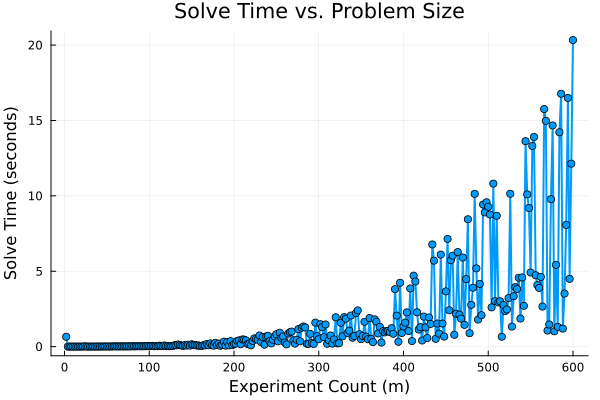

In [8]:
using Dates
using Plots
using Printf

sizes = Int[]
times = Float64[]

for i in 1:300
    filename = @sprintf("%d.in", i)
    tstart = now()
    read_and_solve(filename)
    push!(sizes, i*2)
    tend = now()
    elapsed = (tend - tstart).value / 1000
    push!(times, elapsed)
end

plot(sizes, times,
     xlabel="Experiment Count (m)",
     ylabel="Solve Time (seconds)",
     title="Solve Time vs. Problem Size",
     marker=:circle,
     lw=2,
     legend=false)

Surprisingly, on our largest dataset the LP solver is nearly fifty times slower than the MIP solver! This contradicts our intuition, so we need to investigate the underlying causes. At the same time, we plan to apply the high-performance Dinic algorithm to see how fast the max-flow model can run on this particular problem.

## 3.c Dinic

Dinic (also spelled Dinitz) algorithm was proposed in 1970 and is a **level-graph + staged augmentation** strategy for the maximum-flow problem. The main steps are:

> On the current residual network, construct a level graph using BFS, then repeatedly find augmenting paths within this level graph using DFS until no more augmenting paths exist.

Dinic's algorithm is a classic and even entertaining solution to the max-flow problem. We have adopted Dinic's method and implemented it in Julia to compare its runtime efficiency against traditional non-model-based max-flow algorithms, offering a superior approach for this class of MIP optimization problems with dependency constraints.


In [ ]:
module DinicImpl
export solve_one

const INF32 = Int32(10^9)

mutable struct Edge
    to::Int
    rev::Int
    cap::Int32
end

mutable struct Dinic
    g::Vector{Vector{Edge}}
    level::Vector{Int}
    it::Vector{Int}
end
Dinic(n::Int) = Dinic([Vector{Edge}() for _ in 1:n],
                      zeros(Int,n), ones(Int,n))

function add_edge!(d::Dinic, fr::Int, to::Int, c::Int32)
    push!(d.g[fr], Edge(to, length(d.g[to])+1, c))
    push!(d.g[to], Edge(fr, length(d.g[fr]), 0))
end

function bfs!(d::Dinic, s::Int, t::Int)::Bool
    fill!(d.level, 0)
    q = [s]; d.level[s] = 1
    i = 1
    while i ≤ length(q)
        v = q[i]; i += 1
        for e in d.g[v]
            if e.cap > 0 && d.level[e.to] == 0
                d.level[e.to] = d.level[v] + 1
                push!(q, e.to)
            end
        end
    end
    d.level[t] > 0
end

function dfs!(d::Dinic, v::Int, t::Int, f::Int32)::Int32
    v == t && return f
    gv = d.g[v]
    for idx = d.it[v]:length(gv)
        d.it[v] = idx
        e = gv[idx]
        if e.cap > 0 && d.level[e.to] == d.level[v] + 1
            dcap = dfs!(d, e.to, t, min(f, e.cap))
            if dcap > 0
                gv[idx].cap      -= dcap
                d.g[e.to][e.rev].cap += dcap
                return dcap
            end
        end
    end
    return 0
end

function maxflow!(d::Dinic, s::Int, t::Int)
    flow::Int32 = 0
    while bfs!(d, s, t)
        fill!(d.it, 1)
        while true
            f = dfs!(d, s, t, INF32)
            f == 0 && break
            flow += f
        end
    end
    return flow
end

function solve_one(file::String)
    io = open(file, "r")
    m, n = parse.(Int, split(readline(io)))

    pay  = Int32[]
    need = Vector{Vector{Int}}()
    for _ in 1:m
        row = parse.(Int, split(readline(io)))
        push!(pay,  Int32(row[1]))
        push!(need, row[2:end])
    end
    cost = Int32.(parse.(Int, split(readline(io))))
    close(io)

    N   = 2 + m + n
    s   = 1
    e0  = 1
    i0  = 1 + m
    t   = N
    BIG = Int32(sum(pay))

    d   = Dinic(N)
    for j in 1:m
        ej = e0 + j
        add_edge!(d, s, ej, pay[j])
        for k in need[j]
            @assert 1 ≤ k ≤ n
            add_edge!(d, ej, i0 + k, BIG)
        end
    end
    for k in 1:n
        add_edge!(d, i0 + k, t, cost[k])
    end

    cut = maxflow!(d, s, t)
end

end

Main.DinicImpl

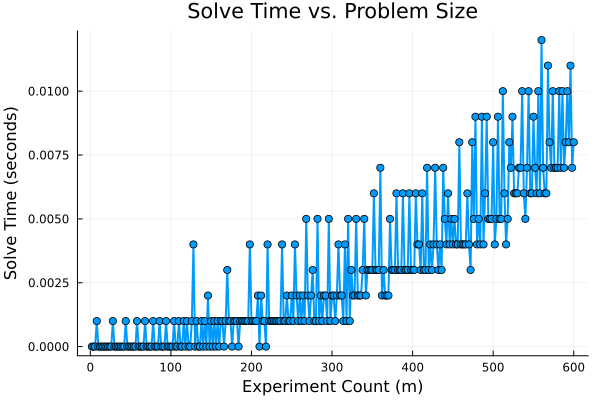

In [14]:
using Dates
using Plots
using Printf
using .DinicImpl

sizes = Int[]
times = Float64[]

for i in 1:300
    tstart = now()
    solve_one("$(i).in")
    push!(sizes, i*2)
    tend = now()
    elapsed = (tend - tstart).value / 1000
    push!(times, elapsed)
end

plot(sizes, times,
     xlabel="Experiment Count (m)",
     ylabel="Solve Time (seconds)",
     title="Solve Time vs. Problem Size",
     marker=:circle,
     lw=2,
     legend=false)

This is the speed we intuitively expected the max‐flow model to achieve: on our largest dataset, it runs nearly sixty times faster than the MIP solver.

In [ ]:
for i in 1:300
    tstart = now()
    solve_one("$(i).in")
    push!(sizes, i*2)
    tend = now()
    elapsed = (tend - tstart).value / 1000
    push!(times, elapsed)
end

plot(sizes, times,
     xlabel="Experiment Count (m)",
     ylabel="Solve Time (seconds)",
     title="Solve Time vs. Problem Size",
     marker=:circle,
     lw=2,
     legend=false)

<a id="Discussion"></a>
## 4. Discussion

Before starting this project, we intuitively expected that solving a linear program (LP) would be much faster than solving a mixed-integer program (MIP). However, when we compared their solution times (see the figure below: left is MIP, right is LP), we found that our LP was consistently slower than the MIP, and the gap widened as the data size increased. On one hand, our initial intuition was mistaken because we did not realize that—even for the same problem—different LP and MIP models involve many distinct elements and thus cannot be directly compared in terms of solve time. On the other hand, we discovered that one key reason is that the LP model has far more variables and constraints than the MIP model. Assuming there are $M$ experiments and $N$ instruments, the MIP has $N + M$ variables and $N \times M$ constraints, whereas the LP has about $N \times M$ variables and roughly $N \times M + N + M$ constraints.


![image2](./image2.jpg)

In addition, we observed that the solve time of the network-flow linear program is unstable. The chart below shows two runs on the same dataset using the LP. 

![image1](./image1.jpg)

Regarding the two observations above, we believe that solvers—by virtue of being general‐purpose—cannot achieve optimal efficiency on any single problem, which may also explain the relative instability in their solve times.This issue could serve as one of our goals for further studying and understanding solver behavior.

Finally, based on the Dinic algorithm's solve-time results (see figure below), we can use this traditional network-flow method to achieve faster solution times.

![image3](./image3.png)

<a id="Conclusion"></a>
## 5. Conclusion

Overall, many factors influence solving speed, and their relative importance can vary depending on the optimization problem. With our current knowledge, it is hard to predict in advance which method will be most efficient. Therefore, understanding and comparing more solver principles and solution techniques is one of our goals. Moreover, a single optimization problem often admits multiple modeling approaches, which can differ greatly in solve time. Our results show that as data size increases, the gap in performance between methods tends to grow, and at industrial‐scale data volumes this gap could stretch to days. Thus, before running on the full dataset, it is wise to experiment first on a smaller sample to identify the most efficient method.